### titulo
en esta etapa se realizara el uso de las redes neuronales para predecir el comportamiento del precio del aceite de soya, para tal motivo se preparo un data set donde se incluye informacion complementaria como sera PIB de Bolivia 

In [1]:
# Importacion de las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Se importa el dataframe de exportaciones previamente limpiado
df = pd.read_csv(r"./data/soya.csv")
print(df.columns)
print(df.shape)

Index(['YEAR', 'MONTH', 'PIB_USD_MILL', 'PROD_SOJA_TON', 'COMM_ACEITE_USD_TON',
       'VALOR_FOB_ACEITE', 'KILBRU_ACEITE', 'VALOR_FOB_TORTA', 'KILBRU_TORTA',
       'COMM_HARINA_USD_TON'],
      dtype='object')
(363, 10)


In [7]:
# se crea la columna de fecha y se ajusta los pesos para que esten en toneladas y no kilogramos
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df = df.set_index('DATE')
df['KILBRU_ACEITE'] = df['KILBRU_ACEITE'].div(1000)
df['KILBRU_TORTA'] = df['KILBRU_TORTA'].div(1000)
df = df.fillna(0)
df.head()

,YEAR,MONTH,PIB_USD_MILL,PROD_SOJA_TON,COMM_ACEITE_USD_TON,VALOR_FOB_ACEITE,KILBRU_ACEITE,VALOR_FOB_TORTA,KILBRU_TORTA,COMM_HARINA_USD_TON
DATE,,,,,,,,,,
1992-01-01,1992,1,307.670824,0.0000,420.421,304451.0,0.365720,1089250.0,4.657464,175.8
1992-02-01,1992,2,306.133843,0.0000,424.389,430771.0,0.509268,3240782.0,14.997048,174.1
1992-03-01,1992,3,304.517081,0.0000,446.436,646738.0,0.771850,1795147.0,6.022430,178.7
1992-04-01,1992,4,347.020861,257568.2249,430.121,595243.0,0.690990,2976684.0,11.647644,172.9
1992-05-01,1992,5,344.642308,0.0000,454.152,169422.0,0.204610,940598.0,5.608295,183.2


como en el dataframe estan los valores de aceite y torta de soya, se procedera y evaluara por partes, en esta primera parte sera solamente el aceite, es un problema de forecasting

In [8]:
# se escogen las columnas predictoras ademas de la 
df_aceite = df.loc[:,['MONTH', 'PIB_USD_MILL', 'COMM_ACEITE_USD_TON',
       'KILBRU_ACEITE', 'VALOR_FOB_ACEITE']]


In [9]:
# se crea esta varible para evaluar las predicciones en los pasos posteriores
df_aceite_test = df_aceite['VALOR_FOB_ACEITE'].to_frame()[326:]

Text(0.5, 1.0, 'Correlation Heatmap')

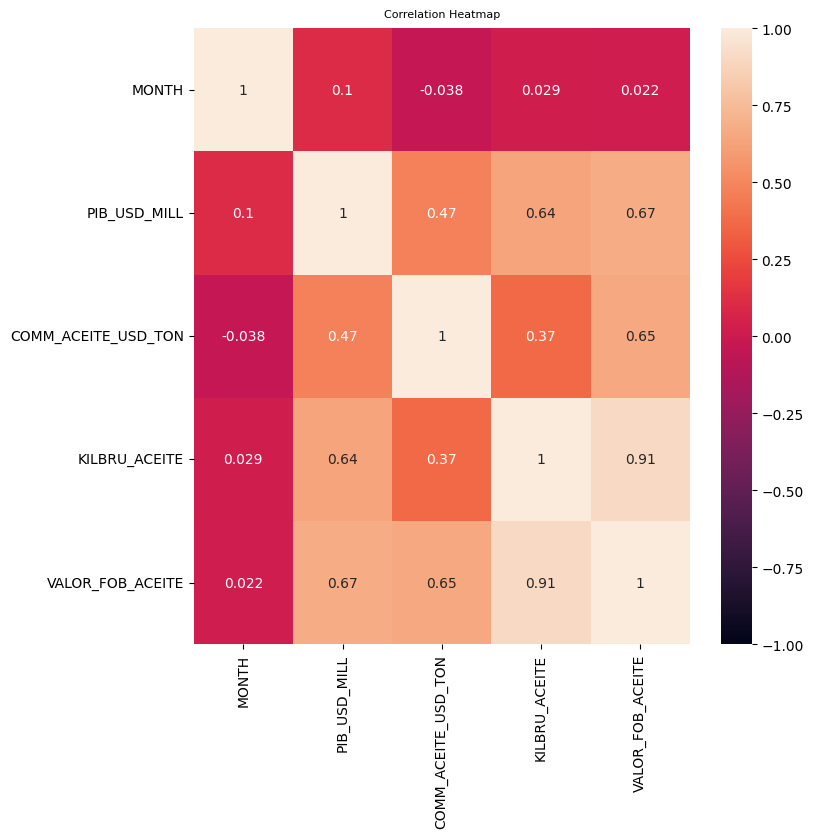

In [14]:
# se realiza un matriz de correlacion para poder ver que tan influyen unas variables con otras
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(df_aceite.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=8)

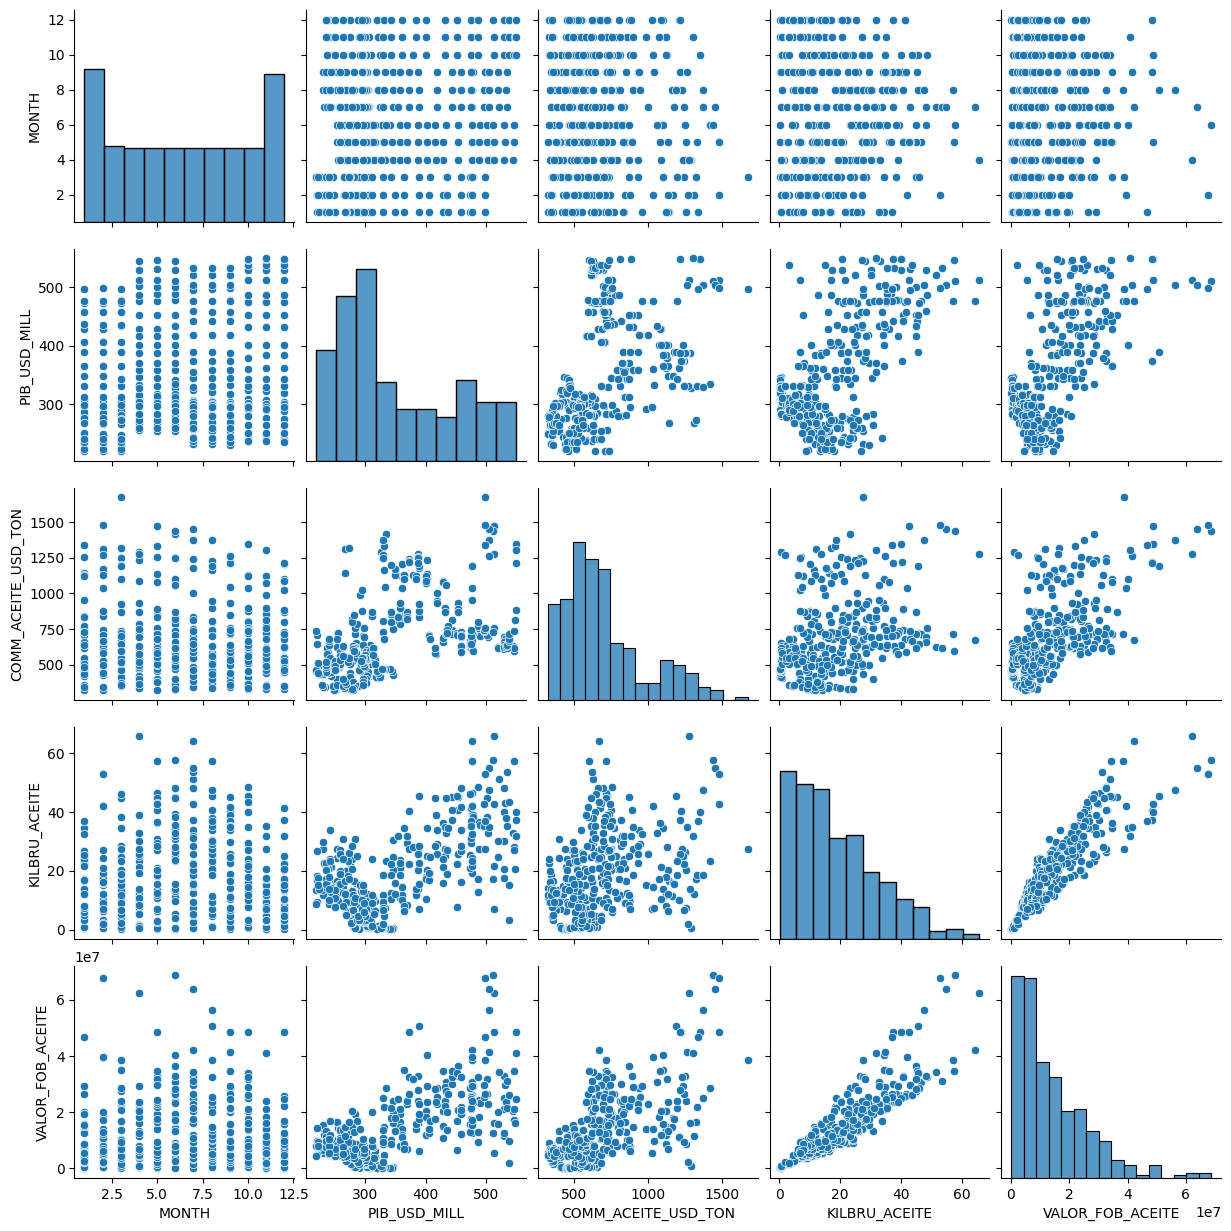

In [12]:
# para tener un mejor panorama del comportamiento de las varibale
sns.pairplot(df_aceite)

In [17]:
# se instalan las nuevas librerias necesarias
from sklearn.preprocessing import StandardScaler

In [24]:
import tensorflow as tf
import os
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam, SGD
from keras.models import load_model
from sklearn.metrics import *

ModuleNotFoundError: No module named 'tensorflow'

In [18]:
# se escalan todas las variables para que esten en la misma dimension
scaler_1 = StandardScaler()
df_aceite_s = scaler_1.fit_transform(df_aceite)
scaler_1.scale_

array([3.46260938e+00, 9.41087910e+01, 2.73852124e+02, 1.38313212e+01,
       1.24648062e+07])

In [19]:
# se define la siguiente funcion para poder acomodar las bariables para poder usarlas en en modelode regresion
def df_to_X_y(df, window_size=4):
  df_as_np = df#.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][4]
    y.append(label)
  return np.array(X), np.array(y)

In [20]:
X, y = df_to_X_y(df_aceite_s,window_size=3)
X.shape, y.shape

((360, 3, 5), (360,))

In [21]:
X_train, y_train = X[:287], y[:287] # hasta 0.8
X_val, y_val = X[287:323], y[287:323] #0.8 a 0.9
X_test, y_test = X[323:], y[323:] #0.9 para adelante
y_test

aqui empiezan la modelacion de los modelos de machine learning

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((3,5)))
model_1.add(LSTM(100, return_sequences=True))
model_1.add(LSTM(50))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, 'linear'))
model_1.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 100)            42400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 75,929
Trainable params: 75,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp_1 = ModelCheckpoint('model_1/', save_best_only=True)

In [ ]:
model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, verbose=0, callbacks=[cp_1])

In [ ]:
model_1 = load_model('model_1/')

se definen estas funciones para poder graficar de forma sencilla, la primera funcion surve para volver las variabvles a la escala que tenian originalmente y la otra sirve apra generar graficas y la tablas para ver como salen los resultados

In [ ]:
def postprocess(arr, scaler):
  arr = (arr*scaler.scale_[4]) + scaler.mean_[4]
  return arr

In [ ]:
def plot_predictions(model, X, y, scaler):
  predictions = model.predict(X).flatten()
  preds = postprocess(predictions, scaler)
  actuals= postprocess(y, scaler)
  df = pd.DataFrame(data={'Predictions': preds,
                          'Actuals':actuals})
  plt.figure(figsize=(15, 5))
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  return df

2/2 [==============================] - 0s 7ms/step


,Predictions,Actuals
0,18312912.0,28670994.64
1,26728876.0,20470837.74
2,26951160.0,34498707.75
3,28973960.0,17210161.06
4,27616792.0,31259909.17
5,27460952.0,23591489.38
6,24152644.0,21531366.82
7,24190168.0,26271841.57
8,21265976.0,1921299.51
9,18001812.0,9779506.98


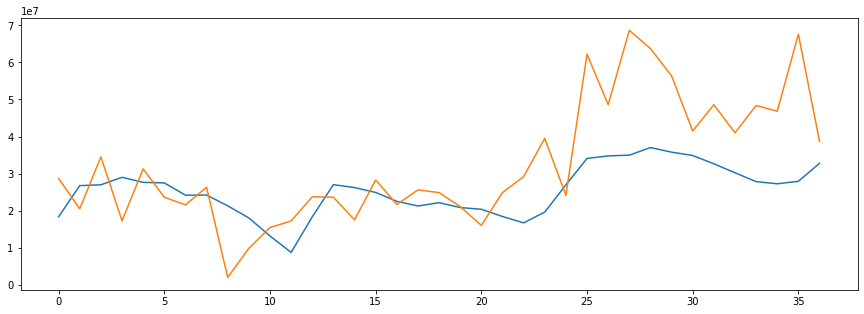

In [ ]:
ltsm_predictions = plot_predictions(model_1, X_test, y_test, scaler_1)
df_aceite_test['lstm'] = ltsm_predictions['Predictions'].to_list()
#ltsm_predictions

In [ ]:
def error(df_test, name, model):
    rmse = np.sqrt(mean_squared_error(df_test[name], df_test[model]))
    mape = mean_absolute_percentage_error(df_test[name], df_test[model])
    r2 = r2_score(df_test[name], df_test[model])
    return rmse, mape, r2

In [ ]:
ltsm_rmse, ltsm_mape, ltsm_r2 = error(df_aceite_test, 'VALOR_FOB_ACEITE', 'ltsm')

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((3,5)))
model_2.add(Conv1D(100, kernel_size=2, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1, 'linear'))
model_2.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 100)            1100      
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                6432      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,565
Trainable params: 7,565
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp_2 = ModelCheckpoint('model_2/', save_best_only=True)

In [ ]:
model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200 , callbacks=[cp_2], verbose=0)

In [ ]:
model_2 = load_model('model_2/')

2/2 [==============================] - 0s 8ms/step


,Predictions,Actuals
0,23085214.0,28670994.64
1,26805108.0,20470837.74
2,31137088.0,34498707.75
3,30564632.0,17210161.06
4,31751584.0,31259909.17
5,28776296.0,23591489.38
6,28251768.0,21531366.82
7,25379534.0,26271841.57
8,22590592.0,1921299.51
9,19428988.0,9779506.98


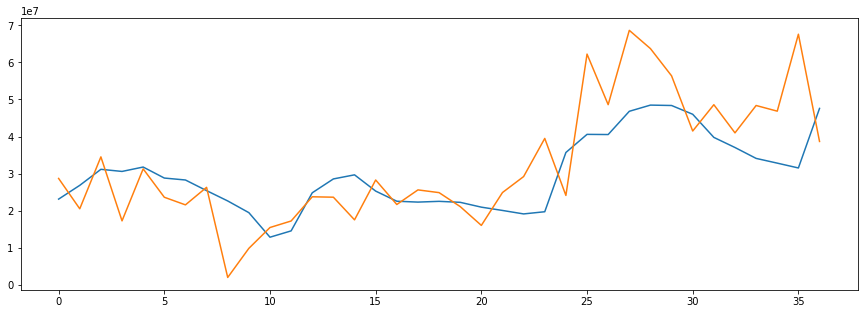

In [ ]:
conv1d_predictions = plot_predictions(model_2, X_test, y_test, scaler_1)
df_aceite_test['conv1d'] = conv1d_predictions['Predictions'].to_list()
#conv1d_predictions

In [ ]:
conv_rmse, conv_mape, conv_r2 = error(df_aceite_test, 'VALOR_FOB_ACEITE', 'conv1d')

In [ ]:
model_3 = Sequential()
model_3.add(InputLayer((3,5)))
model_3.add(GRU(100))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(1, 'linear'))
model_3.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               32100     
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 35,365
Trainable params: 35,365
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp_3 = ModelCheckpoint('model_3/', save_best_only=True)

In [ ]:
model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_3], verbose=0)

In [ ]:
model_3 = load_model('model_3/')

In [ ]:
gru_predictions = plot_predictions(model_3, X_test, y_test, scaler_1)
df_aceite_test['gru'] = gru_predictions['Predictions'].to_list()
gru_predictions

In [ ]:
gru_rmse, gru_mape, gru_r2 = error(df_aceite_test, 'VALOR_FOB_ACEITE', 'gru')

In [ ]:
plt.style.use('fivethirtyeight')

se realiza la siguiente grafica para poder comparar las predicciones realizadas por cada una de las redes neuronales utilizadas


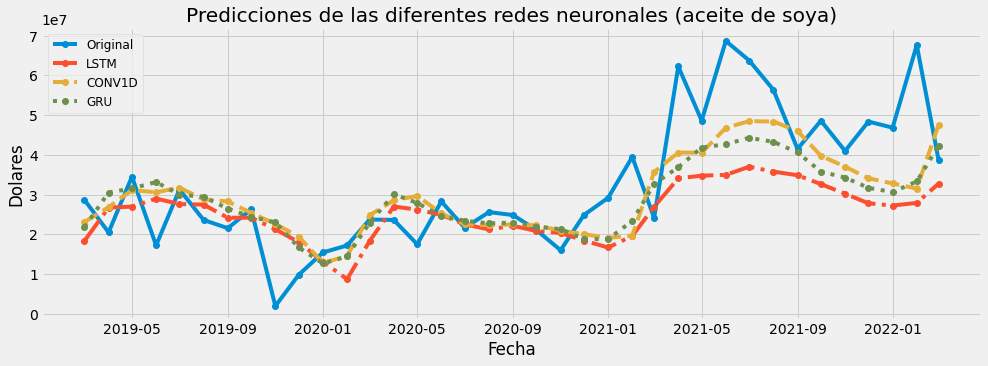

In [ ]:
df_aceite_test
fig, axes = plt.subplots(figsize=(15, 5))
axes.plot_date(df_aceite_test.index, df_aceite_test['VALOR_FOB_ACEITE'], label='Original', linestyle='-')
axes.plot_date(df_aceite_test.index, df_aceite_test['lstm'], label='LSTM', linestyle='-.')
axes.plot_date(df_aceite_test.index, df_aceite_test['conv1d'], label='CONV1D', linestyle='--')
axes.plot_date(df_aceite_test.index, df_aceite_test['gru'], label='GRU', linestyle=':')
axes.legend(fontsize=12)
axes.set_xlabel('Fecha')
axes.set_ylabel('Dolares')
plt.title('Predicciones de las diferentes redes neuronales (aceite de soya)')
plt.show()


In [ ]:
rmse_errors = np.round([ltsm_rmse, conv_rmse, gru_rmse], 3)
mape_errors = np.round([ltsm_mape, conv_mape, gru_mape], 3)
r2_errors = np.round([ltsm_r2, conv_r2, gru_r2], 3)
errors = pd.DataFrame({'Models': ['LTSM', 'CONV1D', 'GRU'], 'RMSE Errors': rmse_errors, 'MAPE Errors': mape_errors, 'R2 Errors': r2_errors})
errors

,Modelos,RMSE Errors,MAPE Errors,R2 Errors
0,LTSM,1.449903e+07,0.564,0.220
1,CONV1D,1.157596e+07,0.546,0.503
2,GRU,1.222647e+07,0.557,0.446


### etapa de harina de soya
bla bla

In [25]:
df_torta = df.loc[:,['MONTH', 'PIB_USD_MILL', 'COMM_HARINA_USD_TON',
       'KILBRU_TORTA', 'VALOR_FOB_TORTA']]

In [ ]:
df_torta_test = df_torta['VALOR_FOB_TORTA'].to_frame()[326:]

Text(0.5, 1.0, 'Correlation Heatmap')

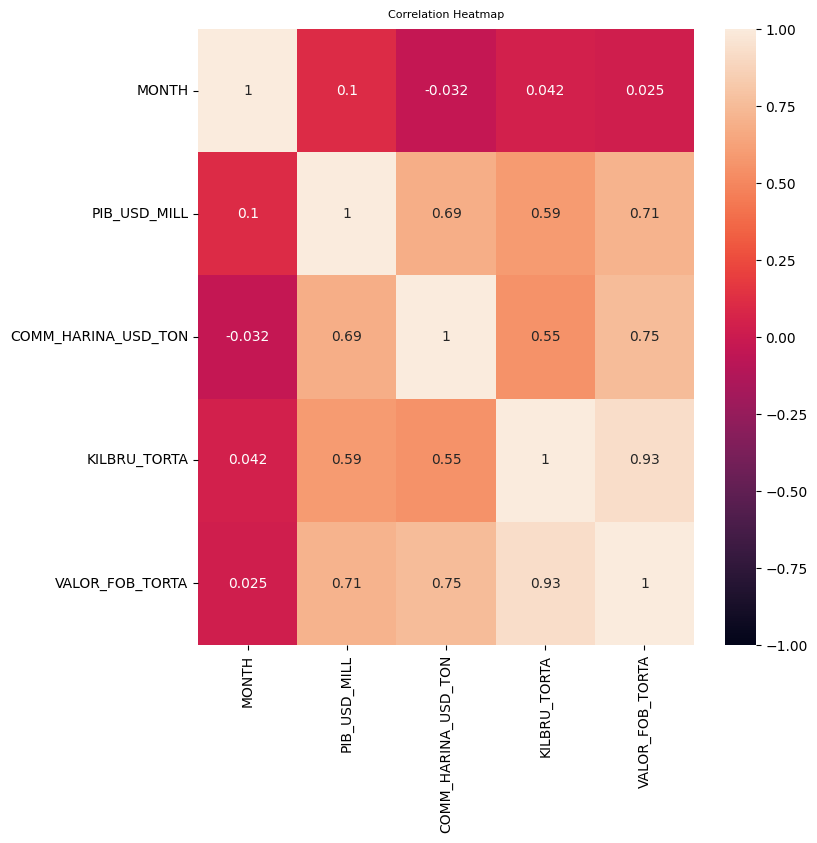

In [26]:
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(df_torta.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=8)

In [ ]:
sns.pairplot(df_torta)

In [27]:
scaler_2 = StandardScaler()
df_torta_s = scaler_2.fit_transform(df_torta)
scaler_2.scale_

array([3.46260938e+00, 9.41087910e+01, 9.61441440e+01, 5.52584359e+01,
       2.08041011e+07])

In [ ]:
X, y = df_to_X_y(df_torta_s,window_size=3)
X.shape, y.shape

In [ ]:
X_train, y_train = X[:287], y[:287] # hasta 0.8
X_val, y_val = X[287:323], y[287:323] #0.8 a 0.9
X_test, y_test = X[323:], y[323:] #0.9 para adelante
y_test

In [ ]:
model_4 = Sequential()
model_4.add(InputLayer((3,5)))
model_4.add(LSTM(100, return_sequences=True))
model_4.add(LSTM(50))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(1, 'linear'))
model_4.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_4.summary()

In [ ]:
cp_4 = ModelCheckpoint('model_4/', save_best_only=True)

In [ ]:
model_4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, verbose=0, callbacks=[cp_4])

In [ ]:
model_4 = load_model('model_4/')

In [ ]:
ltsm_predictions = plot_predictions(model_4, X_test, y_test, scaler_2)
df_torta_test['lstm'] = ltsm_predictions['Predictions'].to_list()
#ltsm_predictions

In [ ]:
ltsm_rmse, ltsm_mape, ltsm_r2 = error(df_torta_test, 'VALOR_FOB_TORTA', 'ltsm')

In [ ]:
model_5 = Sequential()
model_5.add(InputLayer((3,5)))
model_5.add(Conv1D(100, kernel_size=2, activation='relu'))
model_5.add(Flatten())
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1, 'linear'))
model_5.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_5.summary()

In [ ]:
cp_5 = ModelCheckpoint('model_5/', save_best_only=True)

In [ ]:
model_5.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200 , callbacks=[cp_5], verbose=0)

In [ ]:
model_5 = load_model('model_5/')

In [ ]:
conv1d_predictions = plot_predictions(model_5, X_test, y_test, scaler_2)
df_torta_test['conv1d'] = conv1d_predictions['Predictions'].to_list()
#conv1d_predictions

In [ ]:
conv_rmse, conv_mape, conv_r2 = error(df_torta_test, 'VALOR_FOB_TORTA', 'conv1d')

In [ ]:
model_6 = Sequential()
model_6.add(InputLayer((3,5)))
model_6.add(GRU(100))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(1, 'linear'))
model_6.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model_6.summary()

In [ ]:
cp_6 = ModelCheckpoint('model_6/', save_best_only=True)

In [ ]:
model_6.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[cp_6], verbose=0)

In [ ]:
model_6 = load_model('model_6/')

In [ ]:
gru_predictions = plot_predictions(model_6, X_test, y_test, scaler_2)
df_torta_test['gru'] = gru_predictions['Predictions'].to_list()
#gru_predictions

In [ ]:
gru_rmse, gru_mape, gru_r2 = error(df_torta_test, 'VALOR_FOB_TORTA', 'gru')

In [ ]:
df_torta_test
fig, axes = plt.subplots(figsize=(15, 5))
axes.plot_date(df_torta_test.index, df_torta_test['VALOR_FOB_TORTA'], label='Original', linestyle='-')
axes.plot_date(df_torta_test.index, df_torta_test['lstm'], label='LSTM', linestyle='-.')
axes.plot_date(df_torta_test.index, df_torta_test['conv1d'], label='CONV1D', linestyle='--')
axes.plot_date(df_torta_test.index, df_torta_test['gru'], label='GRU', linestyle=':')
axes.legend(fontsize=12)
axes.set_xlabel('Fecha')
axes.set_ylabel('Dolares')
plt.title('Predicciones de las diferentes redes neuronales (torta de soya)')
plt.show()

In [ ]:
rmse_errors = np.round([ltsm_rmse, conv_rmse, gru_rmse], 3)
mape_errors = np.round([ltsm_mape, conv_mape, gru_mape], 3)
r2_errors = np.round([ltsm_r2, conv_r2, gru_r2], 3)
errors = pd.DataFrame({'Models': ['LTSM', 'CONV1D', 'GRU'], 'RMSE Errors': rmse_errors, 'MAPE Errors': mape_errors, 'R2 Errors': r2_errors})
errors